<a href="https://colab.research.google.com/github/DuvvanaPavanKumar/Predictive-Modeling-of-Parkinsons-Disease-Progression-using-LightGBM-Classifier-/blob/main/Copy_of_Untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('parkinson_disease.csv')
pd.set_option('display.max_columns', 10)
df.sample(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
49,16,0,0.25320,0.70885,0.63610,...,3.8775,4.1531,4.6684,3.5196,1
539,179,1,0.41722,0.69852,0.78771,...,4.8850,4.0145,5.8718,5.9461,1
679,226,0,0.65085,0.62437,0.50215,...,5.8204,4.1706,5.3722,7.9296,1
524,174,1,0.82927,0.69312,0.46323,...,2.6304,4.4932,6.7454,31.5223,1
142,47,1,0.70649,0.60081,0.50228,...,32.8153,20.3038,10.8198,3.8632,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [ ]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

In [ ]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:

            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    df = df[filtered_columns]
df.shape

(252, 287)

In [ ]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

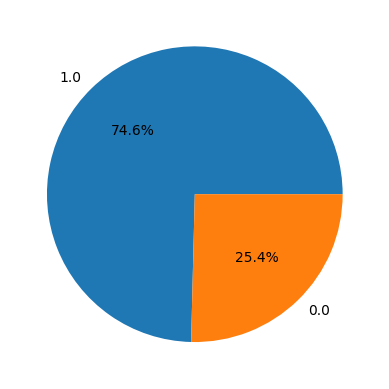

In [ ]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [ ]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

In [ ]:
from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)]
for model in models:
    model.fit(X, Y)  # Use X and Y here
    print(f'{model} : ')

    train_preds = model.predict(X) # Use X here
    print('Training Accuracy : ', ras(Y, train_preds)) # Use Y here

    val_preds = model.predict(X_val)
    print('Validation Accuracy : ', ras(Y_val, val_preds)) # Use Y_val here
    print()

LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.7516556291390728
Validation Accuracy :  0.8166023166023165

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.6467181467181468

SVC(probability=True) : 
Training Accurac